# MIT-GSL Uruguay 

## January 2020

-----

# Week - 2 | Lesson - 01 
# NLP: Intro to Embeddings

1. In the second week look at the Natural Language Processing in greater detail. 
2. We start by introducing word embeddings and apply it to the Stumbleupon data from last week
3. We will gradually move towards more complex applications of NLP while introducing Deep Learning
4. Finally, we will explore applications of NLP in E-commerce

-----

Data 1: Kaggle StumbleUpon Competition
==================
https://www.kaggle.com/c/stumbleupon

** About StumbleUpon **: User-curated web content discovery engine that recommends relevant, high quality pages and media to its users, based on their interests.

** Competition **: 
1. Some pages, such as news articles or seasonal recipes, are only relevant for a short period of time, others maintain a timeless quality and can be recommended to users long after they are discovered. 
2. Goal is to identify pages which are ephemeral and which are evergreen

** Objective **: Build classifier(s) to categorize webpages as evergreen (1) or non-evergreen (0)

** Evaluation **: Area under the curve (AUC)

** Data **: 
* Tab-separated file containing meta-data, webpage text (boilerplate), evergreen classification (target)
* Text based: high-dimensional
* Small sample size: prone to overfitting, high variance in results
    
** Notes **:
* We are only using the *train* data from the competition
* We will create our own split of training-val-test data
 


Data 2: GloVe: Pre-trained word embeddings
==================
https://nlp.stanford.edu/projects/glove/

** About GloVe **: GloVe is an unsupervised learning algorithm for obtaining vector representations for words. 

Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. [https://nlp.stanford.edu/projects/glove/]

-----

Import Python Modules 
=================

In [3]:
# ==============================================
# 0. Module imports
# ==============================================

import pandas as pd
pd.options.display.max_colwidth = 100
import numpy as np
from itertools import product
import csv

# w2v
import gensim

# text processing
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import ToktokTokenizer
import string
import re # regular expressions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

# parallel processing
import multiprocessing
from joblib import delayed, Parallel

# time code
import time

# 2-d visualiztion
%matplotlib inline
from sklearn.manifold import TSNE
from ggplot import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

/home/software/sloan/local/lib/py36/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/software/sloan/local/lib/py36/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/software/sloan/local/lib/py36/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# ==============================================
# Working directory
# ==============================================

import os
os.chdir("/pool001/madhavk/gsl-uruguay/W-02-NLP/")

----

Data import
=================

In [5]:
# ==============================================
# 1. Data import and explore
# ==============================================

local_path = 

# import
train = pd.read_table("/pool001/madhavk/gsl-uruguay/W-01-IntroML/stumble-data/stumbleupon/train.tsv", sep= "\t")

In [6]:
print("Data dimensions:" + str(train.shape))
display(train.head(10))

Data dimensions:(7395, 27)


,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-...,4042,"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-bre...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-07/electronic-futuristic-starting-gun-eliminates-a...,8471,"{""title"":""The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the f...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-fruits?cm_mmc=Facebook-_-MensHealth-_-Content-Heal...,1164,"{""title"":""Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health"",""body...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolproof-tips-for-better-sleep.html,6684,"{""title"":""10 Foolproof Tips for Better Sleep "",""body"":""There was a period in my life when I had ...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the-50-coolest-jerseys-you-didnt-know-existed?show_full=,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen"",""body...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,1,1,14,0,12032,162,10,0.098765,0.082569,0
5,http://www.conveniencemedical.com/genital-herpes-home.php,7018,"{""url"":""conveniencemedical genital herpes home php"",""title"":""Genital Herpes Treatment "",""body"":""...",?,?,119.000000,0.745455,0.581818,0.290909,0.018182,...,?,0,12,?,4368,55,3,0.054545,0.087356,0
6,http://gofashionlane.blogspot.tw/2012/06/american-wild-child.html,8685,"{""title"":""fashion lane American Wild Child "",""body"":""Our favorite summer holiday is just around ...",arts_entertainment,0.22111,0.773810,0.215054,0.053763,0.043011,0.043011,...,1,0,21,0,1287,93,3,0.548387,0.064327,1
7,http://www.insidershealth.com/article/racing_for_recovery/3471,3402,"{""url"":""insidershealth article racing for recovery 3471"",""title"":""Racing For Recovery by Dean Jo...",?,?,1.883333,0.719697,0.265152,0.113636,0.015152,...,?,0,5,?,27656,132,4,0.068182,0.148551,0
8,http://www.valetmag.com/the-handbook/features/31-days/index.php?index1_middle_feature,477,"{""title"":""Valet The Handbook 31 Days 31 days"",""body"":""Resolutions are for suckers Instead of swe...",?,?,0.471503,0.190722,0.036082,0.000000,0.000000,...,1,0,17,0,2471,194,7,0.644330,0.125000,1
9,http://www.howsweeteats.com/2010/03/24/cookies-and-cream-brownies/,6731,"{""url"":""howsweeteats 2010 03 24 cookies and cream brownies"",""title"":""Cookies and Cream Brownies ...",?,?,2.410112,0.469325,0.101227,0.018405,0.003067,...,?,1,14,?,11459,326,4,0.236196,0.094412,1


## Variable descriptions:

1. **url**: Url of the webpage to be classified
2. **urlid**: StumbleUpon's unique identifier for each url
3. **boilerplate**: Boilerplate text
4. **alchemy_category**:	Alchemy category
5. **alchemy_category_score**:	Alchemy category score
6. **avglinksize**:	Average number of words in each link
7. **commonLinkRatio_1**:	# of links sharing at least 1 word with 1 other links / # of links
8. **commonLinkRatio_2**:	# of links sharing at least 1 word with 2 other links / # of links
9. **commonLinkRatio_3**:	# of links sharing at least 1 word with 3 other links / # of links
10. **commonLinkRatio_4**:	# of links sharing at least 1 word with 4 other links / # of links
11. **compression_ratio**:	Compression achieved on this page via gzip (measure of redundancy)
12. **embed_ratio**: Count of number of "embed" usage
13. **frameBased**: A page is frame-based (1) if it has no body markup but have a frameset markup
14. **frameTagRatio**: Ratio of iframe markups over total number of markups
15. **hasDomainLink**:	True (1) if it contains an "a" with an url with domain
16. **html_ratio**:	Ratio of tags vs text in the page
17. **image_ratio**: Ratio of "img" tags vs text in the page
18. **is_news**: True (1) if StumbleUpon's news classifier determines that this webpage is news
19. **lengthyLinkDomain**: True (1) if at least 3 "a"'s text contains more than 30 alphanumeric characters
20. **linkwordscore**: Percentage of words on the page that are in hyperlink's text
21. **news_front_page**: True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
22. **non_markup_alphanum_characters**:	integer	Page's text's number of alphanumeric characters
23. **numberOfLinks**: Number of "a"  markups
24. **numwords_in_url**: Number of words in url
25. **parametrizedLinkRatio**: A link is parametrized if it's url contains parameters  or has an attached onClick event
26. **spelling_errors_ratio**: Ratio of words not found in wiki (considered to be a spelling mistake)
27. **label**: User-determined label. Either evergreen (1) or non-evergreen (0)


---

## Only retain text
We ignore everything but the text and the label to keep the analysis focussed

In [7]:
train = train[["url", "urlid", "boilerplate", "label"]]
print(train.shape)

(7395, 4)


In [8]:
# target variable
train["label"].value_counts()

1    3796
0    3599
Name: label, dtype: int64

In [9]:
# set "?" as missing values
train = train.replace("?", np.nan)
train.head(100)

,url,urlid,boilerplate,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-...,4042,"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-bre...",0
1,http://www.popsci.com/technology/article/2012-07/electronic-futuristic-starting-gun-eliminates-a...,8471,"{""title"":""The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the f...",1
2,http://www.menshealth.com/health/flu-fighting-fruits?cm_mmc=Facebook-_-MensHealth-_-Content-Heal...,1164,"{""title"":""Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health"",""body...",1
3,http://www.dumblittleman.com/2007/12/10-foolproof-tips-for-better-sleep.html,6684,"{""title"":""10 Foolproof Tips for Better Sleep "",""body"":""There was a period in my life when I had ...",1
4,http://bleacherreport.com/articles/1205138-the-50-coolest-jerseys-you-didnt-know-existed?show_full=,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen"",""body...",0
5,http://www.conveniencemedical.com/genital-herpes-home.php,7018,"{""url"":""conveniencemedical genital herpes home php"",""title"":""Genital Herpes Treatment "",""body"":""...",0
6,http://gofashionlane.blogspot.tw/2012/06/american-wild-child.html,8685,"{""title"":""fashion lane American Wild Child "",""body"":""Our favorite summer holiday is just around ...",1
7,http://www.insidershealth.com/article/racing_for_recovery/3471,3402,"{""url"":""insidershealth article racing for recovery 3471"",""title"":""Racing For Recovery by Dean Jo...",0
8,http://www.valetmag.com/the-handbook/features/31-days/index.php?index1_middle_feature,477,"{""title"":""Valet The Handbook 31 Days 31 days"",""body"":""Resolutions are for suckers Instead of swe...",1
9,http://www.howsweeteats.com/2010/03/24/cookies-and-cream-brownies/,6731,"{""url"":""howsweeteats 2010 03 24 cookies and cream brownies"",""title"":""Cookies and Cream Brownies ...",1


In [10]:
# variable types
train.dtypes

url            object
urlid           int64
boilerplate    object
label           int64
dtype: object

In [11]:
# example text
train["boilerplate"][0]

'{"title":"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries","body":"A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose California Photographer Tony Avelar Bloomberg By 2015 your mobile phone will project a 3 D image of anyone who calls and your laptop will be powered by kinetic energy At least that s what International Business Machines Corp sees in its crystal ball The predictions are part of an annual tradition for the Armonk New York based company which surveys its 3 000 researchers to find five ideas expected to take root in the next five years IBM the world s largest provider of computer services looks to Silicon Valley for input gleaning many ideas from its Almaden research center in San Jose

---

# Split data training, validation, and test


In [12]:
# =============================
# Train-val-test split
# =============================

# randomly shuffle data
train = train.sample(frac = 1.0, random_state = 123).reset_index(drop = True)
print(train.shape)
display(train.head())

(7395, 4)


,url,urlid,boilerplate,label
0,http://picturetherecipe.com/index.php/recipes/cute-easy-mini-santa-hat-brownies/,7256,"{""title"":""Mini Santa Hat Brownies Picture the Recipe "",""body"":""Cute Easy Mini Santa Hat Brownies...",0
1,http://www.insidershealth.com/article/identify_the_hidden_signs_of_hypertension/2318,997,"{""url"":""insidershealth article identify the hidden signs of hypertension 2318"",""title"":""Identify...",0
2,http://www.aupairjobs.com/articles/30-blogs-home-to-the-best-mac-and-cheese-recipes/,4237,"{""url"":""aupairjobs articles 30 blogs home to the best mac and cheese recipes"",""title"":""30 Blogs ...",1
3,http://www.seriouseats.com/2011/03/ramen-hacks-30-easy-ways-to-upgrade-your-instant-noodles-japa...,3910,"{""title"":""Slide Show Ramen Hacks 30 Easy Ways to Upgrade Your Instant Noodles "",""body"":""HTML Hin...",1
4,http://www.deliciousmeliscious.com/2009/03/blueberry-hand-pies.html,9426,"{""title"":""Delicious Meliscious a cooking blog by Melissa Blueberry Hand Pies "",""body"":""Hand pies...",1


In [13]:
# =============================
# add indicator for split
# =============================

train["split"] = ["tr"]*3697 + ["va"]*1849 + ["et"]*1849
print(train["split"].value_counts())

tr    3697
va    1849
et    1849
Name: split, dtype: int64


---

Text processing with TFIDF
=============

In [30]:
# =============================
# TFIDF
# =============================

# TFIDF
idf_dtm = TfidfVectorizer(min_df= 10,  max_features= None, strip_accents= "unicode",
                          analyzer= "word", token_pattern= r"\w{1,}", ngram_range=(1, 2), 
                          use_idf= 1, smooth_idf= 1, sublinear_tf= 1)
idf_dtm.fit(train.loc[train["split"] == "tr", "boilerplate"])
train_idf_dtm = idf_dtm.transform(train.loc[train["split"] == "tr", "boilerplate"])
val_idf_dtm = idf_dtm.transform(train.loc[train["split"] == "va", "boilerplate"])
test_idf_dtm = idf_dtm.transform(train.loc[train["split"] == "et", "boilerplate"])
print(train_idf_dtm.shape); print(val_idf_dtm.shape); print(test_idf_dtm.shape)

(3697, 24679)
(1849, 24679)
(1849, 24679)


In [36]:
# =============================
# 4.6 Logistic with 
#     text features
# =============================

# fit logistic regression
logReg4 = LogisticRegression(penalty = "l2", C = 1)
logReg4.fit(train_idf_dtm, train.loc[train["split"] == "tr", "label"])

# predict on validation data
logReg4_val = pd.Series(logReg4.predict(val_idf_dtm))
print(" -- -- -- ")

# auc score
print("Logistic with text features: "  + 
      str(np.round(roc_auc_score(train.loc[train["split"] == "va", "label"], logReg4_val.values), 5)))

 -- -- -- 
Logistic with text features: 0.81234


---

# Pre-trained word embeddings

In [56]:
#===============================================
# glove embeddings
#===============================================

glove = pd.read_table("/pool001/madhavk/gsl-uruguay/W-02-NLP/nlp-data/in-grocery/glove/glove.6B.50d.txt",
                      sep = " ", header = None, 
                      quoting = csv.QUOTE_NONE)
# set column names
glove.columns = ["word"] + ["wv" + str(x + 1) for x in range(glove.shape[1] - 1)]
print(glove.shape)

(400000, 51)


In [57]:
display(glove.head(10))

,word,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,...,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
0,the,0.418000,0.249680,-0.41242,0.121700,0.345270,-0.044457,-0.49688,-0.178620,-0.000660,...,-0.298710,-0.157490,-0.347580,-0.045637,-0.442510,0.187850,0.002785,-0.184110,-0.115140,-0.785810
1,",",0.013441,0.236820,-0.16899,0.409510,0.638120,0.477090,-0.42852,-0.556410,-0.364000,...,-0.080262,0.630030,0.321110,-0.467650,0.227860,0.360340,-0.378180,-0.566570,0.044691,0.303920
2,.,0.151640,0.301770,-0.16763,0.176840,0.317190,0.339730,-0.43478,-0.310860,-0.449990,...,-0.000064,0.068987,0.087939,-0.102850,-0.139310,0.223140,-0.080803,-0.356520,0.016413,0.102160
3,of,0.708530,0.570880,-0.47160,0.180480,0.544490,0.726030,0.18157,-0.523930,0.103810,...,-0.347270,0.284830,0.075693,-0.062178,-0.389880,0.229020,-0.216170,-0.225620,-0.093918,-0.803750
4,to,0.680470,-0.039263,0.30186,-0.177920,0.429620,0.032246,-0.41376,0.132280,-0.298470,...,-0.094375,0.018324,0.210480,-0.030880,-0.197220,0.082279,-0.094340,-0.073297,-0.064699,-0.260440
5,and,0.268180,0.143460,-0.27877,0.016257,0.113840,0.699230,-0.51332,-0.473680,-0.330750,...,-0.069043,0.368850,0.251680,-0.245170,0.253810,0.136700,-0.311780,-0.632100,-0.250280,-0.380970
6,in,0.330420,0.249950,-0.60874,0.109230,0.036372,0.151000,-0.55083,-0.074239,-0.092307,...,-0.486090,-0.008027,0.031184,-0.365760,-0.426990,0.421640,-0.116660,-0.507030,-0.027273,-0.532850
7,a,0.217050,0.465150,-0.46757,0.100820,1.013500,0.748450,-0.53104,-0.262560,0.168120,...,0.138130,0.369730,-0.642890,0.024142,-0.039315,-0.260370,0.120170,-0.043782,0.410130,0.179600
8,"""",0.257690,0.456290,-0.76974,-0.376790,0.592720,-0.063527,0.20545,-0.573850,-0.290090,...,0.030498,-0.395430,-0.385150,-1.000200,0.087599,-0.310090,-0.346770,-0.314380,0.750040,0.970650
9,'s,0.237270,0.404780,-0.20547,0.588050,0.655330,0.328670,-0.81964,-0.232360,0.274280,...,-0.123420,0.659610,-0.518020,-0.829950,-0.082739,0.281550,-0.423000,-0.273780,-0.007901,-0.030231


In [58]:
display(glove.iloc[1000:1010, :])

,word,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,...,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
1000,themselves,0.64757,-0.88334,0.341350,-1.142600,0.61266,0.145310,-0.39535,0.407370,-0.86006,...,-0.21510,-0.77651,0.420400,0.846770,0.34003,0.049138,-0.90712,-0.560780,-0.140280,-0.694590
1001,firm,0.24036,-0.38171,0.210560,0.889300,0.43550,0.218040,-1.10480,-0.172820,0.14027,...,0.83751,-0.64095,0.272330,0.174240,0.18893,-0.172720,-0.77669,0.647720,-0.100460,0.709600
1002,injured,0.52416,-0.33801,1.007700,-0.438480,0.31885,0.559020,-0.91603,1.250700,0.16805,...,-0.54020,0.99150,0.495350,-0.312620,0.97857,-0.128580,-0.68600,-0.009218,0.151710,-0.581400
1003,itself,1.02810,-0.37128,-0.278770,-0.335980,0.52308,0.166720,0.21394,-0.115940,0.38081,...,0.24360,-0.87514,-0.275640,-0.060761,-0.67274,0.517810,-0.10929,-0.221760,0.007997,-0.328420
1004,governor,-0.21253,-0.75435,0.094368,0.095026,0.68000,-0.280770,-0.59397,0.729110,-0.58859,...,-1.27030,1.90030,-1.191700,-1.096600,-1.12400,-0.229460,-1.03160,-0.322850,0.888470,0.877910
1005,movie,0.30824,0.17223,-0.233390,0.023105,0.28522,0.230760,-0.41048,-1.003500,-0.20720,...,-0.29576,1.20900,-0.312700,-0.724620,-0.80801,0.082667,0.26738,-0.981770,-0.321470,0.998230
1006,range,0.63340,0.76075,0.284600,-0.221370,-0.23531,0.107780,-0.18562,-1.115500,0.61539,...,0.29759,0.54568,0.915300,0.171100,-0.11702,-0.381830,1.30270,0.537760,-0.613480,-0.001873
1007,cross,0.34047,0.98554,-0.510130,-0.328380,0.19557,-0.000303,-0.51588,-0.004067,1.01420,...,0.49900,0.15104,0.441790,-0.444580,0.22357,-0.806580,0.51544,-0.373690,-0.170880,-1.064300
1008,track,-0.57660,0.69654,0.491460,0.384090,-1.04320,-0.120990,-0.90199,0.218800,0.75566,...,-0.30526,-0.77774,-0.093377,-0.059172,-0.14357,-0.704150,0.68059,-0.564720,-0.011936,-0.116610
1009,programs,0.04501,0.30760,0.370820,-0.612910,-1.01050,0.177250,-0.82357,-1.455500,0.90333,...,-0.32115,-0.58336,0.071154,0.521910,-0.18888,-0.150410,0.24550,1.131100,-0.593770,1.067600


In [59]:
display(glove.tail(10))

,word,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,...,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
399990,sigarms,-0.743970,0.082164,-0.009147,0.412900,-0.42255,0.101250,-0.186020,0.210510,-0.590370,...,0.533640,-0.932310,-0.390970,0.606380,0.421730,0.106200,-0.148780,-0.11773,-0.097637,0.093382
399991,katuna,-0.300160,-0.802680,-0.466370,-0.298220,-1.03200,-1.070500,0.845620,0.702250,0.119960,...,0.351780,0.147890,-0.015559,0.161850,0.509500,-0.609830,1.248600,0.33713,-0.221360,-0.397560
399992,aqm,-1.116700,0.140570,0.363020,-0.138360,-1.47970,-0.985730,0.404870,-0.397730,-0.401020,...,0.301890,0.048314,-0.079109,0.583750,0.146850,-0.462450,0.442750,0.21229,0.161950,-0.787560
399993,1.3775,-0.241710,-0.233670,0.106720,-1.602300,0.12440,-0.016423,0.130200,0.703180,-0.143010,...,0.779560,-0.072954,0.164430,-0.006193,0.061141,-0.287840,0.586010,0.47279,-0.610840,-0.720910
399994,corythosaurus,-0.042672,-0.088106,-0.317240,-0.252090,-0.26851,-0.066150,0.903250,-0.138180,0.318600,...,-0.381870,-0.911530,0.118530,-0.130340,0.487740,-0.997450,-0.069557,0.24963,0.757910,0.506790
399995,chanty,0.232040,0.025672,-0.706990,-0.045465,0.13989,-0.628070,0.726250,0.341080,0.446140,...,-0.095526,-0.296050,0.385670,0.136840,0.593310,-0.694860,0.124100,-0.18069,-0.258300,-0.039673
399996,kronik,-0.609210,-0.672180,0.235210,-0.111950,-0.46094,-0.007462,0.255780,0.856320,0.055977,...,0.672050,-0.598220,-0.202590,0.392430,0.028873,0.030003,-0.106170,-0.11411,-0.249010,-0.120260
399997,rolonda,-0.511810,0.058706,1.091300,-0.551630,-0.10249,-0.126500,0.995030,0.079711,-0.162460,...,0.024747,0.200920,-1.085100,-0.136260,0.350520,-0.858910,0.067858,-0.25003,-1.125000,1.586300
399998,zsombor,-0.758980,-0.474260,0.473700,0.772500,-0.78064,0.232330,0.046114,0.840140,0.243710,...,0.454390,-0.842540,0.106500,-0.059397,0.090449,0.305810,-0.614240,0.78954,-0.014116,0.644800
399999,sandberger,0.072617,-0.513930,0.472800,-0.522020,-0.35534,0.346290,0.232110,0.230960,0.266940,...,0.688800,-0.179860,-0.066569,-0.480440,-0.559460,-0.275940,0.056072,-0.18907,-0.590210,0.555590


In [60]:
glove.loc[glove["word"] == "uruguay", :]

,word,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,...,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
6841,uruguay,-0.23611,0.031758,-1.0101,1.0408,-0.62919,-0.75547,-0.1614,0.5383,-0.43745,...,-0.45226,-0.15179,1.4332,-1.4858,-0.78428,1.0251,-0.29068,0.10969,0.2023,-1.1487


In [61]:
# samples words
glove.loc[glove["word"] == "news", :]

,word,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,...,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
172,news,-0.20825,0.47786,0.52196,1.0587,-0.10045,-1.1269,-1.2581,-0.11041,-0.074125,...,0.70755,0.52948,-0.12034,-0.46779,0.24722,0.28045,-0.62632,1.4458,0.51045,0.74156


In [62]:
glove.loc[glove["word"] == "football", :]

,word,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,...,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
535,football,-1.8209,0.70094,-1.1403,0.34363,-0.42266,-0.92479,-1.3942,0.28512,-0.78416,...,-0.10665,-0.25377,-0.65102,0.32393,-0.58262,0.88137,-0.13465,0.96903,-0.076259,-0.59909


In [63]:
glove.loc[glove["word"] == "wine", :]

,word,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,...,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
2760,wine,-0.1145,0.75404,-1.6432,-0.61038,0.60352,-0.56396,-1.0069,-0.44103,0.61256,...,0.85632,0.59341,0.4655,-0.0387,0.26463,0.94151,-0.27335,-0.085403,0.12693,-0.23861


### Convert data frame to dictionary

In [64]:
# convert to dictionary
glove_dict = glove.set_index("word").T.to_dict("list")

In [65]:
glove_dict["uruguay"]

[-0.23611,
 0.031758,
 -1.0101,
 1.0408,
 -0.6291899999999999,
 -0.75547,
 -0.1614,
 0.5383,
 -0.43745,
 0.5109199999999999,
 0.9105700000000001,
 0.047937,
 0.11051,
 -0.05014,
 0.55766,
 -0.95499,
 0.42196000000000006,
 -0.69138,
 -0.1365,
 0.39202,
 -0.9861,
 -0.6519,
 0.37806,
 -0.084488,
 -0.4727,
 -0.27675,
 1.5333,
 0.42946999999999996,
 -0.39353,
 -0.55228,
 1.7916,
 0.14078,
 -0.60056,
 0.033476,
 -0.76549,
 -0.24569000000000002,
 -0.70657,
 0.70725,
 0.14833,
 -0.54666,
 -0.45226000000000005,
 -0.15179,
 1.4332,
 -1.4858,
 -0.78428,
 1.0251,
 -0.29068,
 0.10969000000000001,
 0.2023,
 -1.1487]

In [66]:
glove_dict["spanish"]

[0.70881,
 -0.0045872,
 -1.0309,
 0.25621,
 -0.07876799999999999,
 -0.8282299999999999,
 -1.0692,
 0.6019,
 -1.2864,
 0.33568000000000003,
 1.3218,
 0.051735,
 0.50143,
 0.30306,
 0.39058000000000004,
 -1.601,
 -0.75984,
 -0.44891000000000003,
 -0.62745,
 -0.24528000000000003,
 -0.90699,
 -0.20481999999999997,
 -0.58004,
 0.84631,
 -0.28576999999999997,
 -1.1649,
 -0.25523,
 -0.3973,
 -0.38681,
 0.4262,
 3.0625,
 -0.52563,
 -0.8468600000000001,
 0.14209000000000002,
 -0.15395,
 0.074807,
 -0.7343,
 -0.040034,
 -0.3451,
 -0.06625,
 1.0024,
 0.23929,
 0.9549700000000001,
 -0.76798,
 -0.39266999999999996,
 -0.32809,
 -0.37894,
 0.02331,
 0.7792100000000001,
 -1.0226]

### Cosine similarity

In [90]:
cosine_similarity(np.array(glove_dict["uruguay"]).reshape(1, -1) , 
                  np.array(glove_dict["brazil"]).reshape(1, -1))[0][0]

0.8183497977526355

In [91]:
cosine_similarity(np.array(glove_dict["uruguay"]).reshape(1, -1) , 
                  np.array(glove_dict["argentina"]).reshape(1, -1))[0][0]

0.8979324198488632

In [92]:
cosine_similarity(np.array(glove_dict["uruguay"]).reshape(1, -1) , 
                  np.array(glove_dict["japan"]).reshape(1, -1))[0][0]

0.37867554459904523

In [93]:
cosine_similarity(np.array(glove_dict["football"]).reshape(1, -1) , 
                  np.array(glove_dict["cricket"]).reshape(1, -1))[0][0]

0.6960372387108228

In [95]:
cosine_similarity(np.array(glove_dict["football"]).reshape(1, -1) , 
                  np.array(glove_dict["chess"]).reshape(1, -1))[0][0]

0.5743360682116649

In [96]:
cosine_similarity(np.array(glove_dict["football"]).reshape(1, -1) , 
                  np.array(glove_dict["wine"]).reshape(1, -1))[0][0]

0.3083884170170152

-----

# Text processing with word embeddings

### Convert url boilerplate to dense numeric representation

In [97]:
#===============================================
# prepare text
#===============================================

def UrlVectors(d):
    d = word_tokenize(re.sub(r'[^\w\s]', ' ', d.lower()))
    url_vec = []
    for word in d:
        if word in glove_dict:
            url_vec.append(glove_dict[word])
    #print(f"words found: {len(prod_vec)}")        
    if len(url_vec) > 0:
        url_vec = np.array(url_vec)
        url_vec = url_vec.mean(axis = 0)
        return list(url_vec)
    else:
        url_vec = [0]*50
        return url_vec

In [98]:
# create vectors for all urls texts in the data
url_emb = [UrlVectors(d = x) for x in list(train["boilerplate"].values)]
len(url_emb)

7395

In [99]:
# concatenate to data frame
url_emb_df = pd.DataFrame(url_emb)
wv_names = ["wv" + str(x + 1) for x in range(url_emb_df.shape[1])]
url_emb_df.columns = wv_names
display(url_emb_df.head())

,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10,...,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
0,0.041510,0.181525,-0.085215,-0.011608,0.350797,0.278071,-0.298327,-0.110848,-0.155371,-0.031996,...,0.206385,0.002478,-0.044828,-0.035286,0.041510,0.411586,0.164706,-0.155423,-0.003244,-0.167652
1,0.521518,0.209598,0.098528,-0.227196,0.141095,0.427542,-0.199179,-0.115963,0.060226,0.088200,...,-0.186138,0.090097,0.128691,0.372529,0.205025,0.105285,-0.165807,-0.035398,-0.004426,-0.046745
2,0.299496,0.104444,-0.082749,-0.061133,0.339727,0.190016,-0.427312,-0.209175,-0.144600,0.083601,...,-0.006499,0.076887,-0.057867,0.225708,0.065181,0.215427,-0.019181,-0.003670,0.035435,0.078052
3,0.117376,0.112302,0.087256,-0.013397,0.270051,-0.090739,-0.304992,-0.225293,-0.146158,0.148086,...,0.083659,0.097041,-0.072515,0.211319,0.149902,0.137466,0.053404,0.114595,0.153696,0.069790
4,0.141973,0.152366,-0.026666,-0.104184,0.379926,0.245571,-0.309384,-0.035980,-0.148825,-0.138836,...,0.114969,0.001142,-0.037474,0.028116,-0.041061,0.313718,0.063865,-0.179101,-0.097786,-0.167816


In [100]:
# merge with main data
train_wv = pd.concat([train, url_emb_df], axis = 1)
print(train_wv.shape)

(7395, 55)


In [102]:
display(train_wv.head())

,url,urlid,boilerplate,label,split,wv1,wv2,wv3,wv4,wv5,...,wv41,wv42,wv43,wv44,wv45,wv46,wv47,wv48,wv49,wv50
0,http://picturetherecipe.com/index.php/recipes/...,7256,"{""title"":""Mini Santa Hat Brownies Picture the ...",0,tr,0.041510,0.181525,-0.085215,-0.011608,0.350797,...,0.206385,0.002478,-0.044828,-0.035286,0.041510,0.411586,0.164706,-0.155423,-0.003244,-0.167652
1,http://www.insidershealth.com/article/identify...,997,"{""url"":""insidershealth article identify the hi...",0,tr,0.521518,0.209598,0.098528,-0.227196,0.141095,...,-0.186138,0.090097,0.128691,0.372529,0.205025,0.105285,-0.165807,-0.035398,-0.004426,-0.046745
2,http://www.aupairjobs.com/articles/30-blogs-ho...,4237,"{""url"":""aupairjobs articles 30 blogs home to t...",1,tr,0.299496,0.104444,-0.082749,-0.061133,0.339727,...,-0.006499,0.076887,-0.057867,0.225708,0.065181,0.215427,-0.019181,-0.003670,0.035435,0.078052
3,http://www.seriouseats.com/2011/03/ramen-hacks...,3910,"{""title"":""Slide Show Ramen Hacks 30 Easy Ways ...",1,tr,0.117376,0.112302,0.087256,-0.013397,0.270051,...,0.083659,0.097041,-0.072515,0.211319,0.149902,0.137466,0.053404,0.114595,0.153696,0.069790
4,http://www.deliciousmeliscious.com/2009/03/blu...,9426,"{""title"":""Delicious Meliscious a cooking blog ...",1,tr,0.141973,0.152366,-0.026666,-0.104184,0.379926,...,0.114969,0.001142,-0.037474,0.028116,-0.041061,0.313718,0.063865,-0.179101,-0.097786,-0.167816


### Url similarity

In [107]:
#===============================================
# similarity using url vectors
#===============================================

url_sim = cosine_similarity(train_wv.iloc[:, 5:])
url_sim = pd.DataFrame(url_sim)
url_sim.reset_index(inplace = True, drop = True)
url_sim.index = list(train_wv["urlid"].values)
url_sim.columns = list(train_wv["urlid"].values)
display(url_sim.head())

,7256,997,4237,3910,9426,9152,612,6622,8751,4584,...,1002,4253,8613,2517,1405,6506,3275,4545,402,4385
7256,1.000000,0.872028,0.941398,0.920080,0.989636,0.994299,0.925833,0.964253,0.825205,0.900912,...,0.899279,0.870593,0.950436,0.991397,0.878441,0.938263,0.903211,0.911257,0.962901,0.939785
997,0.872028,1.000000,0.957448,0.938891,0.912091,0.865382,0.957880,0.909038,0.914393,0.945711,...,0.963723,0.950770,0.907503,0.874936,0.780189,0.763981,0.952013,0.962379,0.929688,0.925191
4237,0.941398,0.957448,1.000000,0.980649,0.958674,0.930970,0.990527,0.958314,0.894006,0.971940,...,0.973230,0.937377,0.966531,0.925395,0.855114,0.864770,0.971008,0.983060,0.985319,0.979841
3910,0.920080,0.938891,0.980649,1.000000,0.935925,0.904288,0.982877,0.938938,0.883147,0.974748,...,0.957514,0.926055,0.958967,0.902245,0.859569,0.838430,0.968513,0.964707,0.966416,0.960306
9426,0.989636,0.912091,0.958674,0.935925,1.000000,0.986385,0.949175,0.972847,0.873436,0.926036,...,0.939114,0.903855,0.946379,0.990770,0.864264,0.907327,0.935383,0.943171,0.973479,0.948881


In [108]:
# compute similarity
def ComputeUrlSimilarity(urlid, url_sim, top = 5):
    sim = url_sim.loc[:, urlid]
    sim = sim.sort_values(ascending = False)
    sim = sim[1:][0:top]
    sim = pd.DataFrame({"urlid" : list(sim.index), "score": sim}, index = None)
    sim = train_wv.loc[train_wv["urlid"].isin(sim["urlid"]), ["urlid", "url"]]
    return sim

In [120]:
# example
urlid = 7256
print(train_wv.loc[train_wv["urlid"].isin([urlid]), "url"])

0    http://picturetherecipe.com/index.php/recipes/cute-easy-mini-santa-hat-brownies/
Name: url, dtype: object


In [115]:
print(ComputeUrlSimilarity(urlid = urlid, url_sim = url_sim, top = 10).loc[:, "url"])

140                 http://noblepig.com/2010/04/21/mini-baked-cheesecakes-with-strawberries.aspx
1485                   http://www.melskitchencafe.com/2010/10/decadent-chocolate-cheesecake.html
2386                   http://www.best-ever-cookie-collection.com/blueberry-cheesecake-bars.html
2843        http://www.getoffyourbuttandbake.com/2009/06/toasted-marshmallow-smore-cupcakes.html
3246      http://www.browneyedbaker.com/2010/10/28/vanilla-cupcakes-vanilla-buttercream-frosting
3457    http://gimmesomeoven.com/strawberry-lemonade-cupcakes-with-fresh-strawberry-buttercream/
3551                 http://foodbeast.com/content/2011/06/09/butterfinger-fudge-filled-cupcakes/
4437                                http://chaosinthekitchen.com/2009/12/pumpkin-pie-cheesecake/
5104                                        http://www.eatmedelicious.com/search/label/chocolate
6156                     http://ohmysugarhigh.com/triple-chocolate-hazelnut-cookie-pizza-recipe/
Name: url, dtype: object


In [121]:
# example
urlid = 4237
print(train_wv.loc[train_wv["urlid"].isin([urlid]), "url"])

2    http://www.aupairjobs.com/articles/30-blogs-home-to-the-best-mac-and-cheese-recipes/
Name: url, dtype: object


In [122]:
print(ComputeUrlSimilarity(urlid = urlid, url_sim = url_sim, top = 10).loc[:, "url"])

1209                                          http://www.thechangeblog.com/plan-for-diet-success/
1434                                   http://www.marksdailyapple.com/an-open-letter-to-taco-bell
4253             http://www.wisegeek.com/how-can-i-make-the-most-of-an-all-you-can-eat-buffet.htm
4570                              http://blog.ruhlman.com/2010/04/my-essential-kitchen-tools.html
5133                           http://allrecipes.com/Recipe/Naan/Detail.aspx?washelp=1&rid=238644
5370    http://www.organizeit.co.uk/2008/09/15/the-5-simplest-healthy-habits-you-will-ever-learn/
5672                                                                     http://greenavocado.com/
5730                                http://justcooknyc.com/2011/04/14/recipe-writing-cheat-sheet/
6375                                                                       http://missvickie.com/
6953                                                           http://www.alwaysorderdessert.com/
Name: url, dtype: ob

In [123]:
# example
urlid = 997
print(train_wv.loc[train_wv["urlid"].isin([urlid]), "url"])

1    http://www.insidershealth.com/article/identify_the_hidden_signs_of_hypertension/2318
Name: url, dtype: object


In [124]:
print(ComputeUrlSimilarity(urlid = urlid, url_sim = url_sim, top = 10).loc[:, "url"])

89                               http://www.insidershealth.com/article/could_you_be_at_risk_for_stroke/2580
664                            http://www.caring.com/articles/10-things-your-bladder-says-about-your-health
1043               http://www.insidershealth.com/article/new_hope_for_those_suffering_from_hepatitis_c/4904
1474                                                                     http://www.fibromyalgiacauses.net/
1818               http://www.insidershealth.com/article/depression_raises_impotence_risk_in_diabetics/3700
4715    http://www.insidershealth.com/article/tired_and_pale_it_might_be_more_than_just_the_winter_blahs...
5556                           http://www.uspharmd.com/blog/2011/10-scariest-side-effects-of-sleeplessness/
6471    http://www.insidershealth.com/article/do_you_have_this_common_digestive_disorder_and_just_not_kn...
7123                                          http://www.thirdage.com/fibromyalgia/truth-about-fibromyalgia
7362    http://www.npr.org/b

---

# Logistic regression

In [129]:
# =============================
# 4.6 Logistic with 
#     text features
# =============================

# fit logistic regression
logReg_wv = LogisticRegression(penalty = "l2", C = 1)
logReg_wv.fit(train_wv.loc[train_wv["split"] == "tr", wv_names], 
              train_wv.loc[train_wv["split"] == "tr", "label"])

# predict on validation data
logReg_wv_val = pd.Series(logReg_wv.predict(train_wv.loc[train_wv["split"] == "va", wv_names]))
print(" -- -- -- ")

# auc score
print("Logistic with text features: "  + 
      str(np.round(roc_auc_score(train_wv.loc[train_wv["split"] == "va", "label"], logReg_wv_val.values), 5)))

 -- -- -- 
Logistic with text features: 0.80135


-----

-----

# Introduction to Deep Learning

In [142]:
# ================================
# Tensorflow and keras
# ================================

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import SimpleRNN

----

## Text pre-processing in Keras

In [15]:
# declare vocabulary size
max_words = 10000

In [44]:
txt_tokenize = Tokenizer(num_words= max_words)
txt_tokenize.fit_on_texts(train["boilerplate"].values)
url_word_seq = txt_tokenize.texts_to_sequences(train["boilerplate"].values)
print(len(url_word_seq))

7395


In [45]:
# converted to numeric indices
url_word_seq[0]

[49,
 947,
 3499,
 3455,
 846,
 726,
 1,
 55,
 33,
 1440,
 172,
 947,
 3499,
 3455,
 846,
 847,
 566,
 129,
 331,
 5607,
 10,
 112,
 5027,
 4,
 2691,
 1,
 417,
 250,
 1,
 84,
 890,
 6,
 1,
 55,
 325,
 531,
 21,
 6284,
 47,
 29,
 553,
 104,
 6,
 1,
 675,
 42,
 72,
 1,
 84,
 54,
 7,
 897,
 1,
 66,
 6,
 1,
 80,
 10,
 26,
 114,
 1,
 325,
 4,
 922,
 13,
 2,
 10,
 912,
 16,
 240,
 44,
 1964,
 361,
 9,
 1,
 9039,
 259,
 2230,
 947,
 1183,
 1270,
 846,
 18,
 504,
 694,
 1183,
 1270,
 846,
 1458,
 1170,
 55,
 166,
 27,
 19,
 27,
 1285,
 5265,
 27,
 177,
 66,
 457,
 18,
 584,
 19,
 19,
 27,
 56,
 722,
 1342,
 313,
 248,
 7639,
 177,
 5,
 34,
 706,
 4859,
 117,
 156,
 4229,
 56,
 5,
 372,
 2066,
 18,
 2177,
 1262,
 954,
 19,
 897,
 1,
 80,
 916,
 6,
 3,
 154,
 148,
 15,
 234,
 141,
 27,
 72,
 1,
 66,
 2,
 84,
 2,
 246,
 3705,
 40,
 20,
 461,
 506,
 59,
 23,
 16,
 528,
 7,
 25,
 72,
 1,
 913,
 2,
 246,
 6,
 1,
 248,
 45,
 2503,
 3,
 4642,
 18,
 69,
 1,
 148,
 251,
 1,
 174,
 622,
 12,
 1,
 27,
 5,

In [46]:
word_index = txt_tokenize.word_index
len(word_index)

92198

In [47]:
max([max(x) for x in url_word_seq])

9999

In [48]:
word_index

{'the': 1,
 'and': 2,
 'a': 3,
 'to': 4,
 'of': 5,
 'in': 6,
 'you': 7,
 'it': 8,
 'for': 9,
 'i': 10,
 'is': 11,
 'with': 12,
 'that': 13,
 's': 14,
 'on': 15,
 'this': 16,
 'your': 17,
 'or': 18,
 '1': 19,
 'are': 20,
 'as': 21,
 'from': 22,
 'at': 23,
 'be': 24,
 'can': 25,
 'have': 26,
 '2': 27,
 'but': 28,
 'by': 29,
 't': 30,
 'was': 31,
 'if': 32,
 'body': 33,
 'all': 34,
 'not': 35,
 'more': 36,
 'one': 37,
 'an': 38,
 'my': 39,
 'they': 40,
 'about': 41,
 'so': 42,
 'we': 43,
 'up': 44,
 '4': 45,
 'will': 46,
 'out': 47,
 'url': 48,
 'title': 49,
 'like': 50,
 'into': 51,
 'make': 52,
 'just': 53,
 'when': 54,
 'recipe': 55,
 'cup': 56,
 'has': 57,
 'time': 58,
 '3': 59,
 'until': 60,
 'them': 61,
 'some': 62,
 'what': 63,
 'food': 64,
 'how': 65,
 'chocolate': 66,
 'these': 67,
 'do': 68,
 'over': 69,
 'he': 70,
 'minutes': 71,
 'add': 72,
 'get': 73,
 'their': 74,
 'there': 75,
 'com': 76,
 'recipes': 77,
 'then': 78,
 'new': 79,
 'butter': 80,
 'no': 81,
 'which': 82,
 'als

### Padding

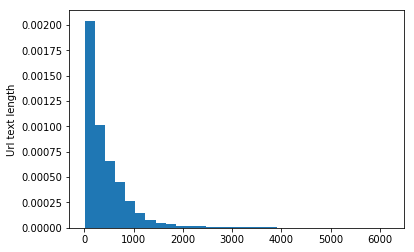

In [49]:
original_length = [len(x) for x in url_word_seq]
plt.hist(original_length, normed = True, bins=30)
plt.ylabel('Url text length');

In [50]:
print(np.mean(original_length))
print(np.median(original_length))

438.6815415821501
281.0


In [51]:
# pad word sequences
max_len = 200
url_word_seq = pad_sequences(url_word_seq, maxlen= max_len)

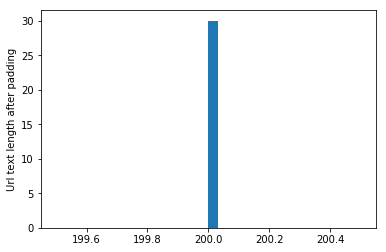

In [52]:
padded_length = [len(x) for x in url_word_seq]
plt.hist(padded_length, normed = True, bins= 30)
plt.ylabel('Url text length after padding');

## Combine words with word vectors from glove

In [69]:
# set embedding dimension
emb_dim = 50

# initialize embedding matrix
emb_mat = np.zeros((max_words, emb_dim))
print(emb_mat.shape)

(10000, 50)


In [70]:
emb_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
for word, i in word_index.items():
    if i < max_words:
        emb_vector = glove_dict.get(word)
        if emb_vector is not None:
            emb_mat[i] = emb_vector

In [72]:
emb_mat

array([[ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.418  ,  0.24968, -0.41242, ..., -0.18411, -0.11514, -0.78581],
       [ 0.26818,  0.14346, -0.27877, ..., -0.6321 , -0.25028, -0.38097],
       ...,
       [ 0.70514, -1.1757 , -1.0082 , ..., -0.56846, -0.4371 , -0.18936],
       [ 1.4984 ,  0.18257, -0.78043, ...,  0.20317,  0.44381,  0.45725],
       [-0.7251 ,  0.26577, -0.30092, ..., -0.61753, -0.90142,  0.58013]])

### Split train, val, and test data

In [94]:
# data
train_dt = url_word_seq[train.loc[train["split"] == "tr", :].index.values]
val_dt = url_word_seq[train.loc[train["split"] == "va", :].index.values]
test_dt = url_word_seq[train.loc[train["split"] == "et", :].index.values]
print(len(train_dt))
print(len(val_dt))
print(len(test_dt))

3697
1849
1849


In [101]:
# labels
y_train = train.loc[train["split"] == "tr", "label"].values
y_val = train.loc[train["split"] == "va", "label"].values
y_test = train.loc[train["split"] == "et", "label"].values
print(len(y_train))
print(len(y_val))
print(len(y_test))

3697
1849
1849


-----

# Building our first "DL" model

### Without pre-trained embeddings

In [97]:
model = Sequential()
model.add(Embedding(max_words, emb_dim, input_length= max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 50)           500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 820,065
Trainable params: 820,065
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.compile(optimizer= 'rmsprop',
              loss= 'binary_crossentropy',
              metrics= ['acc'])

In [104]:
history = model.fit(train_dt, y_train,
                    epochs= 10,
                    batch_size= 32,
                    validation_data= (val_dt, y_val))

Train on 3697 samples, validate on 1849 samples
Epoch 1/10
3697/3697 [==============================] - 11s 3ms/step - loss: 0.5493 - acc: 0.7092 - val_loss: 0.4747 - val_acc: 0.7815
Epoch 2/10
3697/3697 [==============================] - 1s 170us/step - loss: 0.2841 - acc: 0.8842 - val_loss: 0.4860 - val_acc: 0.7891
Epoch 3/10
3697/3697 [==============================] - 1s 167us/step - loss: 0.1165 - acc: 0.9570 - val_loss: 0.5436 - val_acc: 0.7842
Epoch 4/10
3697/3697 [==============================] - 1s 173us/step - loss: 0.0566 - acc: 0.9789 - val_loss: 0.6299 - val_acc: 0.7631
Epoch 5/10
3697/3697 [==============================] - 1s 173us/step - loss: 0.0325 - acc: 0.9889 - val_loss: 0.7113 - val_acc: 0.7772
Epoch 6/10
3697/3697 [==============================] - 1s 160us/step - loss: 0.0229 - acc: 0.9922 - val_loss: 0.9585 - val_acc: 0.7161
Epoch 7/10
3697/3697 [==============================] - 1s 170us/step - loss: 0.0179 - acc: 0.9930 - val_loss: 1.1817 - val_acc: 0.6625
E

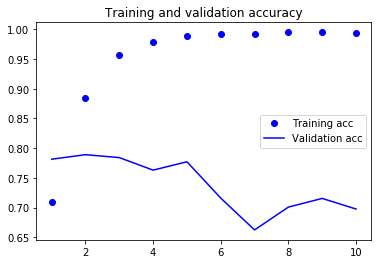

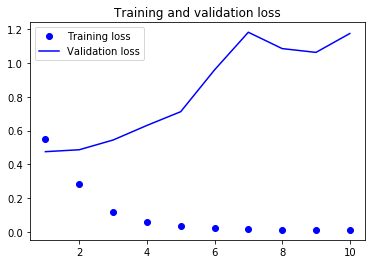

In [107]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [114]:
# prediction on validation data
val_pred = model.predict(val_dt)
val_pred

array([[0.4554105 ],
       [0.5518797 ],
       [0.2579479 ],
       ...,
       [0.6931595 ],
       [0.75198567],
       [0.39772555]], dtype=float32)

In [115]:
np.round(roc_auc_score(y_val, val_pred), 5)

0.6241

----

### With pre-trained embeddings

In [126]:
model = Sequential()
model.add(Embedding(max_words, emb_dim, input_length= max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [127]:
# set embedding weights
model.layers[0].set_weights([emb_mat])
model.layers[0].trainable = False

In [128]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 50)           500000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 820,065
Trainable params: 320,065
Non-trainable params: 500,000
_________________________________________________________________


In [129]:
model.compile(optimizer= 'rmsprop',
              loss= 'binary_crossentropy',
              metrics= ['acc'])

In [130]:
history = model.fit(train_dt, y_train,
                    epochs= 2,
                    batch_size= 32,
                    validation_data= (val_dt, y_val))

Train on 3697 samples, validate on 1849 samples
Epoch 1/2
3697/3697 [==============================] - 1s 206us/step - loss: 0.5330 - acc: 0.7582 - val_loss: 0.4879 - val_acc: 0.7864
Epoch 2/2
3697/3697 [==============================] - 1s 149us/step - loss: 0.3600 - acc: 0.8472 - val_loss: 0.5040 - val_acc: 0.7815


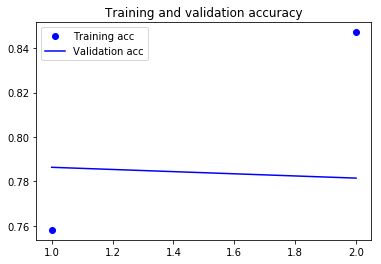

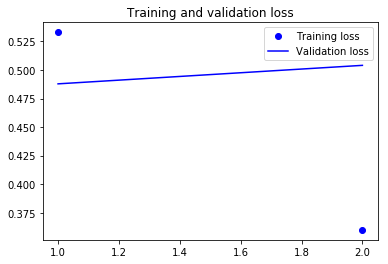

In [131]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [132]:
# prediction on validation data
val_pred = model.predict(val_dt)
np.round(roc_auc_score(y_val, val_pred), 5)

0.84922

----

### With trainable pre-trained embeddings

In [134]:
model = Sequential()
model.add(Embedding(max_words, emb_dim, input_length= max_len))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [135]:
# set embedding weights
model.layers[0].set_weights([emb_mat])

In [136]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 50)           500000    
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dense_14 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 1,784,289
Trainable params: 1,784,289
Non-trainable params: 0
_________________________________________________________________


In [137]:
model.compile(optimizer= 'rmsprop',
              loss= 'binary_crossentropy',
              metrics= ['acc'])

In [138]:
history = model.fit(train_dt, y_train,
                    epochs= 10,
                    batch_size= 32,
                    validation_data= (val_dt, y_val))

Train on 3697 samples, validate on 1849 samples
Epoch 1/10
3697/3697 [==============================] - 1s 313us/step - loss: 0.6102 - acc: 0.7463 - val_loss: 0.5347 - val_acc: 0.7664
Epoch 2/10
3697/3697 [==============================] - 1s 219us/step - loss: 0.3644 - acc: 0.8442 - val_loss: 0.5430 - val_acc: 0.7826
Epoch 3/10
3697/3697 [==============================] - 1s 218us/step - loss: 0.2073 - acc: 0.9134 - val_loss: 0.6890 - val_acc: 0.7642
Epoch 4/10
3697/3697 [==============================] - 1s 229us/step - loss: 0.1016 - acc: 0.9646 - val_loss: 1.5373 - val_acc: 0.7123
Epoch 5/10
3697/3697 [==============================] - 1s 221us/step - loss: 0.0567 - acc: 0.9821 - val_loss: 0.9917 - val_acc: 0.7712
Epoch 6/10
3697/3697 [==============================] - 1s 220us/step - loss: 0.0394 - acc: 0.9854 - val_loss: 1.3601 - val_acc: 0.7263
Epoch 7/10
3697/3697 [==============================] - 1s 223us/step - loss: 0.0324 - acc: 0.9922 - val_loss: 1.2783 - val_acc: 0.7593


In [139]:
# prediction on validation data
val_pred = model.predict(val_dt)
np.round(roc_auc_score(y_val, val_pred), 5)

0.81138

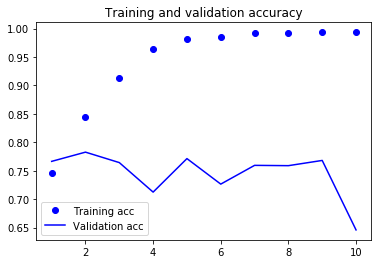

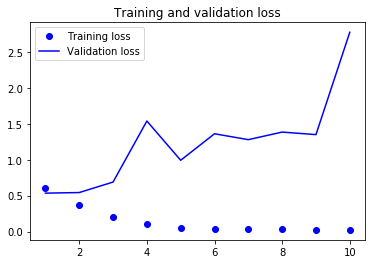

In [140]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

-----

# Class exercise - Try your own architecture

In [141]:
# Build your own DL model that you think will work best on this data.
# Feel free to add more dense layers and/or increase the number of the hidden units per layer
# Note you may have to train for longer if you use a bigger network (more epochs)

----

# Simple RNN

In [170]:
model = Sequential()
model.add(Embedding(max_words, emb_dim, input_length= max_len))
model.add(SimpleRNN(32)) 
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 50)           500000    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2656      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 502,689
Trainable params: 502,689
Non-trainable params: 0
_________________________________________________________________


In [171]:
# set embedding weights
model.layers[0].set_weights([emb_mat])
model.layers[0].trainable = False

In [172]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 50)           500000    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2656      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 502,689
Trainable params: 2,689
Non-trainable params: 500,000
_________________________________________________________________


In [173]:
model.compile(optimizer= 'rmsprop',
              loss= 'binary_crossentropy',
              metrics= ['acc'])

In [174]:
history = model.fit(train_dt, y_train,
                    epochs= 10,
                    batch_size= 128,
                    validation_data= (val_dt, y_val))

Train on 3697 samples, validate on 1849 samples
Epoch 1/10
3697/3697 [==============================] - 3s 851us/step - loss: 0.6262 - acc: 0.6340 - val_loss: 0.5647 - val_acc: 0.7150
Epoch 2/10
3697/3697 [==============================] - 3s 741us/step - loss: 0.5184 - acc: 0.7514 - val_loss: 0.5183 - val_acc: 0.7512
Epoch 3/10
3697/3697 [==============================] - 3s 743us/step - loss: 0.4837 - acc: 0.7841 - val_loss: 0.5075 - val_acc: 0.7804
Epoch 4/10
3697/3697 [==============================] - 3s 740us/step - loss: 0.4785 - acc: 0.7833 - val_loss: 0.5120 - val_acc: 0.7745
Epoch 5/10
3697/3697 [==============================] - 3s 726us/step - loss: 0.4704 - acc: 0.7885 - val_loss: 0.4977 - val_acc: 0.7734
Epoch 6/10
3697/3697 [==============================] - 3s 728us/step - loss: 0.4658 - acc: 0.7904 - val_loss: 0.4957 - val_acc: 0.7772
Epoch 7/10
3697/3697 [==============================] - 3s 744us/step - loss: 0.4692 - acc: 0.7879 - val_loss: 0.5187 - val_acc: 0.7480


In [175]:
# prediction on validation data
val_pred = model.predict(val_dt)
np.round(roc_auc_score(y_val, val_pred), 5)

0.80822

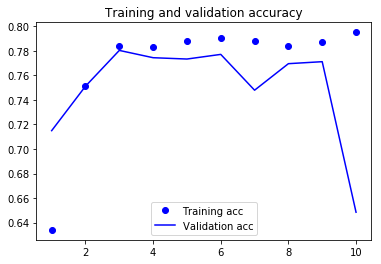

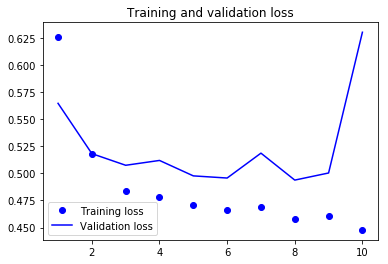

In [176]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

-----

# Class exercise - A more expressive RNN

In [164]:
# Try increasing the number of dense layers after the RNN
# Maybe train for more epochs?
# You can also allow training the emebdding layer or even train the embeddding layer from scratch

----

# Lesson summary

### What we've learned:
1. Word embeddings
2. Using pre-trained word embeddings with linear models
3. Introduction to DL with Keras
4. Processing text with Keras
    1. tokenization, word indices, padding, 
5. Using pre-trained word embeddings in DL models
6. Training your own embeddings
7. Mointoring loss and accuracy during training
8. Simple RNNs

----